Assignment 1 

In [101]:
import numpy as np
import matplotlib.pyplot as plt
from google.colab import widgets
!pip install gymnasium matplotlib numpy
import gymnasium as gym
from gymnasium import spaces
import time
import random
import pickle
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import pickle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [102]:
class Gridworld(gym.Env):
  def __init__(self,environment_type):
    self.state = np.zeros((4,4))
    self.environment_type = environment_type
    self.environment_width = 4
    self.environment_height = 4
    self.diamond_quantity = 1
    observation = self.state.flatten()
    self.observation_space = spaces.Discrete(16) #no of states
    self.action_space = spaces.Discrete(4) #no of actions 
    self.max_timesteps = 10
    self.agent_position = [0, 3]
    self.coin1_position = [1, 3]
    self.diamond_position = [2,2]
    self.bomb_position = [1, 1]
    self.coin2_position = [3,1]  
    self.goal_position = [3,3]

  def step(self, action):
    if action == 0:
      self.agent_position[0] += 1
    if action == 1:
      self.agent_position[0] -= 1
    if action == 2:
      self.agent_position[1] += 1
    if action == 3:
      self.agent_position[1] -= 1

    #check if agent position is within bounderies
    self.agent_position = np.clip(self.agent_position, 0, 3)

    # Initialize the state rewards
    self.state[tuple(self.agent_position)] = 1
    self.state[tuple(self.coin1_position)] = 2
    self.state[tuple(self.coin2_position)] = 5
    self.state[tuple(self.bomb_position)] = -4
    self.state[tuple(self.diamond_position)] = 9  
    self.state[tuple(self.goal_position)]= 10
    agent_state= self.agent_position

    # Calculates the reward for the action
    reward= 0
    if (self.agent_position == self.coin1_position).all():
      reward = reward +2
    if (self.agent_position == self.bomb_position).all():
      reward = reward - 4
    if(self.agent_position == self.coin2_position).all():
      reward = reward + 5
    if (self.agent_position == self.diamond_position).all():
      reward = reward + 9
    if (self.agent_position == self.goal_position).all():
      reward = reward + 10

    self.timestep += 1
    terminated = True if self.timestep >= self.max_timesteps else False
    truncated = True if np.all((self.agent_position >=0 ) & (self.agent_position <= 2)) else False
    
    info = {}
    observation = self.agent_position
    #find the index
    # observation = np.where(observation == 1)[0][0]

    return observation, reward, terminated, truncated, info

  def reset(self):
    self.timestep = 0
    self.agent_position = [0, 3]
    self.coin1_position = [1, 3]
    self.diamond_position = [2,2]
    self.bomb_position = [1, 1]
    self.coin2_position = [3,1]
    
   
    self.goal_position = [3,3]
    self.state[tuple(self.agent_position)]= 1
    self.state[tuple(self.coin1_position)]= 2
    self.state[tuple(self.coin2_position)]= 5
    self.state[tuple(self.bomb_position)]= -4
    self.state[tuple(self.diamond_position)] = 9  
    self.state[tuple(self.goal_position)]= 10
    observation = self.state.flatten()
    info = {}

    return self.agent_position, info

  def render(self):
    fig, ax = plt.subplots(figsize=(4, 4))
    ax.set_xlim(0, 4)
    ax.set_ylim(4,0)
    # plt.imshow(self.state)

    def plot_image(plot_pos):
            """This is a helper function to render the environment. It checks which objects are in a particular
            position on the grid and renders the appropriate image.

            :param arr plot_pos: Co-ordinates of the grid position which needs to be rendered."""

            # Initially setting every object to not be plotted.
            plot_agent, plot_coin1 ,plot_bomb, plot_diamond, plot_coin2 = \
                False, False, False, False, False
  
   
            # Checking which objects need to be plotted by comparing their positions.
            if np.array_equal(self.agent_position, plot_pos):
                plot_agent = True
            if np.array_equal(self.coin1_position, plot_pos):
                plot_coin1 = True
            if self.diamond_quantity > 0:  # Gold isn't plotted if it has already been picked by one of the agents.
                if np.array_equal(plot_pos, self.diamond_position):
                    plot_diamond = True
            if np.array_equal(self.bomb_position, plot_pos):
                plot_bomb = True
            if np.array_equal(self.coin2_position, plot_pos):
                plot_coin2 = True

            # Plot for Agent.
            if plot_agent and \
                    all(not item for item in
                        [plot_coin1, plot_diamond, plot_bomb, plot_coin2]):
                agent = AnnotationBbox(OffsetImage(plt.imread('./pingu.png'), zoom=0.1),
                                       np.add(plot_pos, [0.3, 0.3]), frameon=False)
                ax.add_artist(agent)

            # Plot for coin1
            elif plot_coin1 and \
                    all(not item for item in
                        [plot_agent, plot_diamond, plot_bomb, plot_coin2]):
                coin1 = AnnotationBbox(OffsetImage(plt.imread('./coin1.png'), zoom=0.1),
                                        np.add(plot_pos, [0.5, 0.5]), frameon=False)
                ax.add_artist(coin1)

            # Plot for diamond
            elif plot_diamond and \
                    all(not item for item in
                        [plot_agent, plot_coin1, plot_bomb, plot_coin2]):
                diamond = AnnotationBbox(OffsetImage(plt.imread('./diamond.png'), zoom=0.1),
                                      np.add(plot_pos, [0.5, 0.5]), frameon=False)
                ax.add_artist(diamond)

            # Plot for bomb
            elif plot_bomb and \
                    all(not item for item in
                        [plot_agent, plot_coin1, plot_diamond, plot_coin2]):
                bomb = AnnotationBbox(OffsetImage(plt.imread('./bom.png'), zoom=0.1),
                                     np.add(plot_pos, [0.5, 0.5]), frameon=False)
                ax.add_artist(bomb)

            # Plot for coin2
            elif plot_coin2 and \
                    all(not item for item in
                        [plot_agent, plot_coin1, plot_diamond, plot_bomb]):
                coin2 = AnnotationBbox(OffsetImage(plt.imread('./coin2.png'), zoom=0.1),
                                        np.add(plot_pos, [0.5, 0.5]), frameon=False)
                ax.add_artist(coin2)
            
            # Plot for Agent and coin1
            elif all(item for item in [plot_agent, plot_coin1]) and \
                     all(not item for item in
                         [plot_agent, plot_coin1]):
                 agent_coin1 = AnnotationBbox(OffsetImage(plt.imread('./agent_coin1.png'),
                                                           zoom=0.04), np.add(plot_pos, [0.4, 0.3]), frameon=False)
                 ax.add_artist(agent_coin1)

            # Plot for Agent and coin1
            elif all(item for item in [plot_agent, plot_diamond]) and \
                     all(not item for item in
                         [plot_agent, plot_diamond]):
                 agent_diamond = AnnotationBbox(OffsetImage(plt.imread('./agent_diamond.png'),
                                                           zoom=0.04), np.add(plot_pos, [0.4, 0.3]), frameon=False)
                 ax.add_artist(agent_diamond)

            # Plot for Agent and bom
            elif all(item for item in [plot_agent, plot_bomb]) and \
                     all(not item for item in
                         [plot_agent, plot_bomb]):
                 agent_bomb = AnnotationBbox(OffsetImage(plt.imread('./agent_bom.png'),
                                                           zoom=0.04), np.add(plot_pos, [0.4, 0.3]), frameon=False)
                 ax.add_artist(agent_bomb)
            
            # Plot for Agent and coin2
            elif all(item for item in [plot_agent, plot_coin2]) and \
                     all(not item for item in
                         [plot_agent, plot_coin2]):
                 agent_coin2 = AnnotationBbox(OffsetImage(plt.imread('./agent_coin2.png'),
                                                           zoom=0.04), np.add(plot_pos, [0.4, 0.3]), frameon=False)
                 ax.add_artist(agent_coin2)

            # Plot for Agent and diamond
            elif all(item for item in [plot_agent, plot_diamond]) and \
                     all(not item for item in
                         [plot_agent, plot_diamond]):
                 agent_diamond = AnnotationBbox(OffsetImage(plt.imread('./agent_diamond.png'),
                                                           zoom=0.04), np.add(plot_pos, [0.4, 0.3]), frameon=False)
                 ax.add_artist(agent_diamond)
                     
            

    coordinates_state_mapping_2 = {}
    for j in range(self.environment_height * self.environment_width):
            coordinates_state_mapping_2[j] = np.asarray(
                [j % self.environment_width, int(np.floor(j / self.environment_width))])

        # Rendering the images for all states.
    for position in coordinates_state_mapping_2:
            plot_image(coordinates_state_mapping_2[position])

    plt.xticks([0, 1, 2, 3])
    plt.yticks([0, 1, 2, 3])
    plt.grid()

   # Displaying the plot.
    plt.show()


In [103]:
class StochasticGridworld(gym.Env):
  def __init__(self,environment_type):
    self.state = np.zeros((4,4))
    self.environment_type = environment_type
    self.environment_width = 4
    self.environment_height = 4
    self.diamond_quantity = 1
    observation = self.state.flatten()
    self.observation_space = spaces.Discrete(16) #no of states
    self.action_space = spaces.Discrete(4) #no of actions 
    self.max_timesteps = 10
    self.agent_position = [0, 3]
    self.coin1_position = [1, 3]
    self.diamond_position = [2,2]
    self.bomb_position = [1, 1]
    self.coin2_position = [3,1]  
    self.goal_position = [3,3]

  def step(self, action):
    choice = []
    if random.uniform(0,1) >= 0.75:
      for i in range(self.action_space.n):
        choice.append(i)
      action = random.choice(choice)
    observation = self.state.flatten()

    # if action == 'right':
    #    self.agentState = (self.state[0], self.state[1]+1)
    # elif action == 'left':
    #    self.agentState = (self.state[0], self.state[1]-1)
    # elif action == 'up':
    #   self.agentState = (self.state[0]-1, self.state[1])
    # else:
    #    self.agentState = (self.state[0]+1, self.state[1])
    if action == 0:
      self.agent_position[0] += 1
    if action == 1:
      self.agent_position[0] -= 1
    if action == 2:
      self.agent_position[1] += 1
    if action == 3:
      self.agent_position[1] -= 1

    #check if agent position is within bounderies
    self.agent_position = np.clip(self.agent_position, 0, 3)

    # if np.any(self.state >= self.grid) or np.any(self.state < 0):
    #         self.reset()
    #         return self.state, -1, True, {}
    # else:
    #         return self.state, 0, False, {} 

    # Initialize the state rewards
    self.state[tuple(self.agent_position)] = 1
    self.state[tuple(self.coin1_position)] = 2
    self.state[tuple(self.coin2_position)] = 5
    self.state[tuple(self.bomb_position)] = -4
    self.state[tuple(self.diamond_position)] = 9  
    self.state[tuple(self.goal_position)]= 10
    agent_state= self.agent_position

    # Calculates the reward for the action
    reward= 0
    if (self.agent_position == self.coin1_position).all():
      reward = reward +2
    if (self.agent_position == self.bomb_position).all():
      reward = reward - 4
    if(self.agent_position == self.coin2_position).all():
      reward = reward + 5
    if (self.agent_position == self.diamond_position).all():
      reward = reward + 9
    if (self.agent_position == self.goal_position).all():
      reward = reward + 10

    self.timestep += 1
    terminated = True if self.timestep >= self.max_timesteps else False
    truncated = True if np.all((self.agent_position >=0 ) & (self.agent_position <= 2)) else False

    #terminate
    # if(self.timestep >= self.max_timesteps) or (self.agent_position == self.goal_position).all():
    #       terminated = True
    # else:
    #       truncated = False
    
    info = {}
    return self.agent_position , reward, terminated, truncated, info

  def reset(self):
    self.timestep = 0
    self.agent_position = [0, 3]
    self.coin1_position = [1, 3]
    self.diamond_position = [2,2]
    self.bomb_position = [1, 1]
    self.coin2_position = [3,1]
    
   
    self.goal_position = [3,3]
    self.state[tuple(self.agent_position)]= 1
    self.state[tuple(self.coin1_position)]= 2
    self.state[tuple(self.coin2_position)]= 5
    self.state[tuple(self.bomb_position)]= -4
    self.state[tuple(self.diamond_position)] = 9  
    self.state[tuple(self.goal_position)]= 10
    observation = self.state.flatten()
    info = {}

    return self.agent_position, info

  def render(self):
    fig, ax = plt.subplots(figsize=(4, 4))
    ax.set_xlim(0, 4)
    ax.set_ylim(4,0)
    # plt.imshow(self.state)

    def plot_image(plot_pos):
            """This is a helper function to render the environment. It checks which objects are in a particular
            position on the grid and renders the appropriate image.

            :param arr plot_pos: Co-ordinates of the grid position which needs to be rendered."""

            # Initially setting every object to not be plotted.
            plot_agent, plot_coin1 ,plot_bomb, plot_diamond, plot_coin2 = \
                False, False, False, False, False
  
   
            # Checking which objects need to be plotted by comparing their positions.
            if np.array_equal(self.agent_position, plot_pos):
                plot_agent = True
            if np.array_equal(self.coin1_position, plot_pos):
                plot_coin1 = True
            if self.diamond_quantity > 0:  # Gold isn't plotted if it has already been picked by one of the agents.
                if np.array_equal(plot_pos, self.diamond_position):
                    plot_diamond = True
            if np.array_equal(self.bomb_position, plot_pos):
                plot_bomb = True
            if np.array_equal(self.coin2_position, plot_pos):
                plot_coin2 = True

            # Plot for Agent.
            if plot_agent and \
                    all(not item for item in
                        [plot_coin1, plot_diamond, plot_bomb, plot_coin2]):
                agent = AnnotationBbox(OffsetImage(plt.imread('./pingu.png'), zoom=0.1),
                                       np.add(plot_pos, [0.3, 0.3]), frameon=False)
                ax.add_artist(agent)

            # Plot for coin1
            elif plot_coin1 and \
                    all(not item for item in
                        [plot_agent, plot_diamond, plot_bomb, plot_coin2]):
                coin1 = AnnotationBbox(OffsetImage(plt.imread('./coin1.png'), zoom=0.1),
                                        np.add(plot_pos, [0.5, 0.5]), frameon=False)
                ax.add_artist(coin1)

            # Plot for diamond
            elif plot_diamond and \
                    all(not item for item in
                        [plot_agent, plot_coin1, plot_bomb, plot_coin2]):
                diamond = AnnotationBbox(OffsetImage(plt.imread('./diamond.png'), zoom=0.1),
                                      np.add(plot_pos, [0.5, 0.5]), frameon=False)
                ax.add_artist(diamond)

            # Plot for bomb
            elif plot_bomb and \
                    all(not item for item in
                        [plot_agent, plot_coin1, plot_diamond, plot_coin2]):
                bomb = AnnotationBbox(OffsetImage(plt.imread('./bom.png'), zoom=0.1),
                                     np.add(plot_pos, [0.5, 0.5]), frameon=False)
                ax.add_artist(bomb)

            # Plot for coin2
            elif plot_coin2 and \
                    all(not item for item in
                        [plot_agent, plot_coin1, plot_diamond, plot_bomb]):
                coin2 = AnnotationBbox(OffsetImage(plt.imread('./coin2.png'), zoom=0.1),
                                        np.add(plot_pos, [0.5, 0.5]), frameon=False)
                ax.add_artist(coin2)
            # Plot for Agent and coin1
            elif all(item for item in [plot_agent, plot_coin1]) and \
                     all(not item for item in
                         [plot_agent, plot_coin1]):
                 agent_coin1 = AnnotationBbox(OffsetImage(plt.imread('./agent_coin1.png'),
                                                           zoom=0.04), np.add(plot_pos, [0.4, 0.3]), frameon=False)
                 ax.add_artist(agent_coin1)

            # Plot for Agent and coin1
            elif all(item for item in [plot_agent, plot_diamond]) and \
                     all(not item for item in
                         [plot_agent, plot_diamond]):
                 agent_diamond = AnnotationBbox(OffsetImage(plt.imread('./agent_diamond.png'),
                                                           zoom=0.04), np.add(plot_pos, [0.4, 0.3]), frameon=False)
                 ax.add_artist(agent_diamond)

            # Plot for Agent and bom
            elif all(item for item in [plot_agent, plot_bomb]) and \
                     all(not item for item in
                         [plot_agent, plot_bomb]):
                 agent_bomb = AnnotationBbox(OffsetImage(plt.imread('./agent_bom.png'),
                                                           zoom=0.04), np.add(plot_pos, [0.4, 0.3]), frameon=False)
                 ax.add_artist(agent_bomb)
            
            # Plot for Agent and coin2
            elif all(item for item in [plot_agent, plot_coin2]) and \
                     all(not item for item in
                         [plot_agent, plot_coin2]):
                 agent_coin2 = AnnotationBbox(OffsetImage(plt.imread('./agent_coin2.png'),
                                                           zoom=0.04), np.add(plot_pos, [0.4, 0.3]), frameon=False)
                 ax.add_artist(agent_coin2)

            # Plot for Agent and diamond
            elif all(item for item in [plot_agent, plot_diamond]) and \
                     all(not item for item in
                         [plot_agent, plot_diamond]):
                 agent_diamond = AnnotationBbox(OffsetImage(plt.imread('./agent_diamond.png'),
                                                           zoom=0.04), np.add(plot_pos, [0.4, 0.3]), frameon=False)
                 ax.add_artist(agent_diamond)
            

    coordinates_state_mapping_2 = {}
    for j in range(self.environment_height * self.environment_width):
            coordinates_state_mapping_2[j] = np.asarray(
                [j % self.environment_width, int(np.floor(j / self.environment_width))])

        # Rendering the images for all states.
    for position in coordinates_state_mapping_2:
            plot_image(coordinates_state_mapping_2[position])

    plt.xticks([0, 1, 2, 3])
    plt.yticks([0, 1, 2, 3])
    plt.grid()

   # Displaying the plot.
    plt.show()


In [104]:
class QLearningAgent:
    def __init__(self, env, epsilon = 0.98, learning_rate=0.19, gamma = 0.9):

        self.env = env
        self.observation_space = spaces.Discrete(env.environment_width * env.environment_height)
        self.learning_rate = learning_rate
        self.gamma = gamma
        self.actions = env.action_space
        self.q_learning_table = np.zeros((env.environment_width, env.environment_height, self.actions.n))
        self.epsilon_value = epsilon
    
    def update(self, current_state, action, reward, next_state):
        current_q = self.q_learning_table[current_state[0]][current_state[1]][action]
        if next_state is None: #check if next state is none , if yes set max_qvalue for next state as 0
            maxq_nextstate = 0
        else: 
            maxq_nextstate = np.max(self.q_learning_table[next_state[0]][next_state[1]]) #estimates the max Qvalue for next state from the Qtable

        new_q = current_q + self.learning_rate * reward + (self.gamma * maxq_nextstate) - current_q
        self.q_learning_table[current_state[0]][current_state[1]][action] = new_q

    def policy(self, state):
        if np.random.uniform(0, 1) < self.epsilon_value:
            return np.random.choice(self.actions.n-1)
        else:
            return np.argmax(self.q_learning_table[int(state[0]), int(state[1])])

    def step(self, state):
        return self.policy(state)

    def epsilon(self, epsilon):
        self.epsilon_value = epsilon

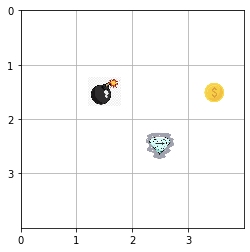

        *************           


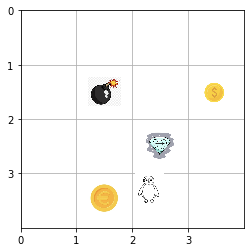

        *************           


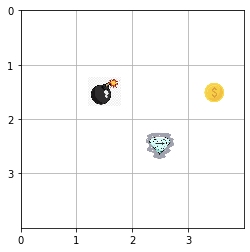

        *************           


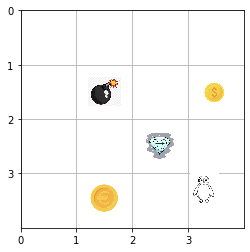

        *************           


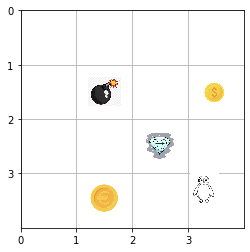

        *************           


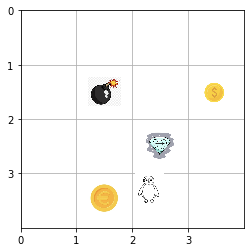

        *************           


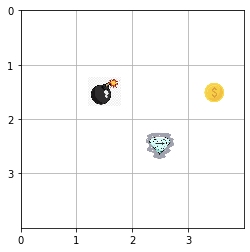

        *************           


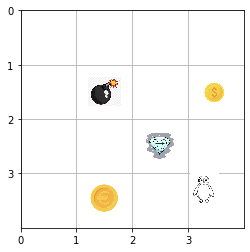

        *************           


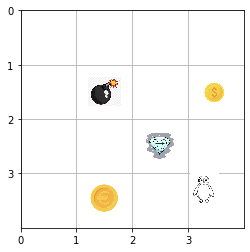

        *************           


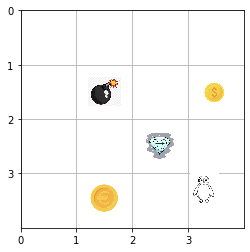

        *************           


In [105]:
env = Gridworld('deterministic')
agent = QLearningAgent(env)
episodes = 1000
min_epsilon = 0.1
epsilon_values = []
rewards_values = []

def train(agent, env, epsilon):
    obs, info = env.reset()
    terminated = False
    epsilon_values.append(agent.epsilon_value)
    curr_reward = 0

    while not terminated:
        action = agent.step(obs)
        state = np.copy(obs)
        obs, reward, terminated, truncated, info = env.step(action)

        curr_reward += reward
        next_state = np.copy(obs)
        agent.update(state, action, reward, next_state)

    rewards_values.append(curr_reward)
    agent.epsilon(max(min_epsilon, epsilon * 0.999))
for episode in range(episodes):
    epsilon = agent.epsilon_value
    train(agent, env, epsilon)
    if episode % 100 == 0:
        env.render()
        plt.show()
        print('        *************           ')

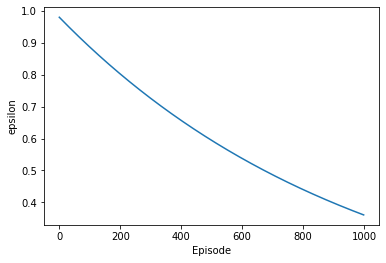

In [106]:
plt.xlabel('Episode')
plt.ylabel('epsilon')
plt.plot(epsilon_values)
     

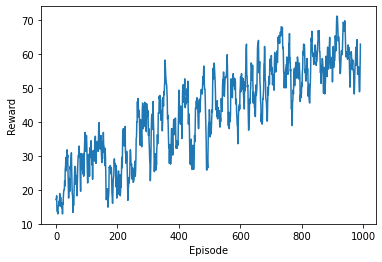

In [107]:
window_size = 9
plt.xlabel('Episode')
plt.ylabel('Reward')
rewards = [np.mean(rewards_values[i:i+window_size]) for i in range(len(rewards_values)-window_size+1)]
plt.plot(rewards)
plt.show()

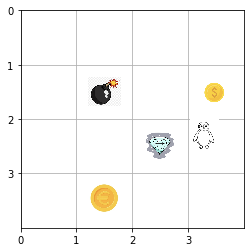

        *************           


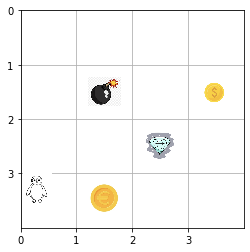

        *************           


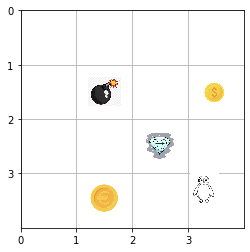

        *************           


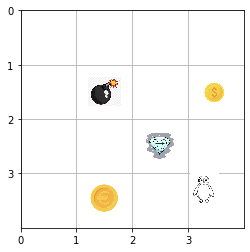

        *************           


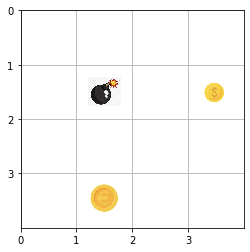

        *************           


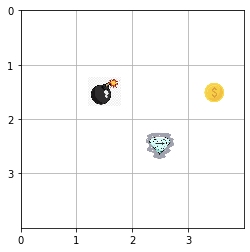

        *************           


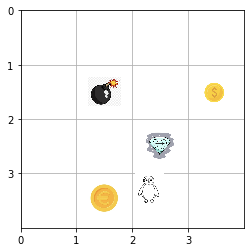

        *************           


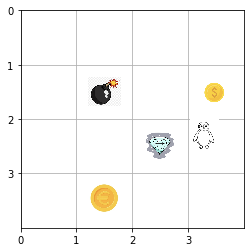

        *************           


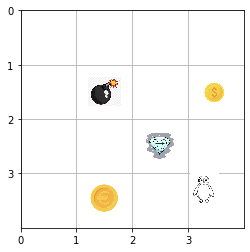

        *************           


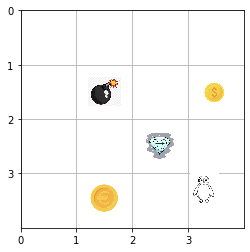

        *************           


In [108]:
env = StochasticGridworld('Stochastic')
agent = QLearningAgent(env)
episodes = 1000
min_epsilon = 0.1
epsilon_values = []
rewards_values = []

def train(agent, env, epsilon):
    obs, info = env.reset()
    terminated = False
    epsilon_values.append(agent.epsilon_value)
    curr_reward = 0

    while not terminated:
        action = agent.step(env.agent_position)
        state = np.copy(env.agent_position)
        obs, reward, terminated, truncated, info = env.step(action)

        curr_reward += reward
        next_state = np.copy(obs)
        agent.update(state, action, reward, env.agent_position)

    rewards_values.append(curr_reward)
    agent.epsilon(max(min_epsilon, epsilon * 0.999))
for episode in range(episodes):
    epsilon = agent.epsilon_value
    train(agent, env, epsilon)
    if episode % 100 == 0:
        env.render()
        plt.show()
        print('        *************           ')

In [109]:
print(epsilon_values)
print(rewards_values)

[0.98, 0.97902, 0.97804098, 0.97706293902, 0.97608587608098, 0.975109790204899, 0.9741346804146941, 0.9731605457342793, 0.9721873851885451, 0.9712151978033565, 0.9702439826055531, 0.9692737386229475, 0.9683044648843245, 0.9673361604194403, 0.9663688242590208, 0.9654024554347618, 0.964437052979327, 0.9634726159263477, 0.9625091433104214, 0.961546634167111, 0.9605850875329438, 0.9596245024454109, 0.9586648779429654, 0.9577062130650225, 0.9567485068519574, 0.9557917583451054, 0.9548359665867603, 0.9538811306201735, 0.9529272494895533, 0.9519743222400637, 0.9510223479178237, 0.9500713255699059, 0.949121254244336, 0.9481721329900917, 0.9472239608571016, 0.9462767368962445, 0.9453304601593482, 0.9443851296991889, 0.9434407445694897, 0.9424973038249201, 0.9415548065210952, 0.9406132517145741, 0.9396726384628595, 0.9387329658243967, 0.9377942328585723, 0.9368564386257138, 0.935919582187088, 0.934983662604901, 0.934048678942296, 0.9331146302633537, 0.9321815156330904, 0.9312493341174573, 0.9303

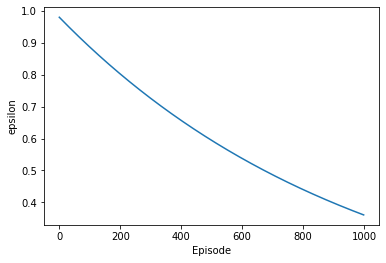

In [110]:
plt.xlabel('Episode')
plt.ylabel('epsilon')
plt.plot(epsilon_values)

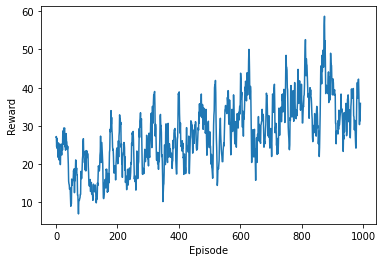

In [111]:
plt.xlabel('Episode')
plt.ylabel('Reward')
rewards = [np.mean(rewards_values[i:i+window_size]) for i in range(len(rewards_values)-window_size+1)]
plt.plot(rewards)
plt.show()

In [112]:
with open('q_tableQ.pickle', 'wb') as f:
    pickle.dump(agent.q_learning_table, f)

In [113]:
class SarsaAgent:
    def __init__(self, env, alpha=0.5, gamma=0.6, epsilon=0.92):
      self.env = env
      self.alpha = alpha
      self.epsilon_value = epsilon
      self.actions = env.action_space
      self.gamma = gamma
      self.q_learning_table = np.zeros((env.environment_width, env.environment_height, self.actions.n))
      Q = np.zeros((env.observation_space.n, env.action_space.n))

    def policy(self, state):
        if np.random.uniform(0, 1) < self.epsilon_value:
            action = np.random.randint(self.actions.n-1)
        else:
            action = np.argmax(self.q_learning_table[state[0]][state[1]])
        return action
    
    def update(self, current_state, action, reward, next_state, next_action):
        target = reward + self.gamma * self.q_learning_table[next_state[0]][next_state[1]][next_action]
        loss = target - self.q_learning_table[current_state[0]][current_state[1]][action]
        self.q_learning_table[current_state[0]][current_state[1]][action] += self.alpha * loss
    
    def step(self, state):
        return self.policy(state)

    def epsilon(self, epsilon):
        self.epsilon_value = epsilon

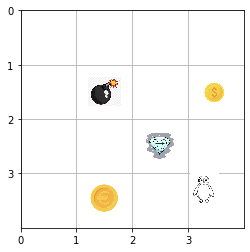

        *************           


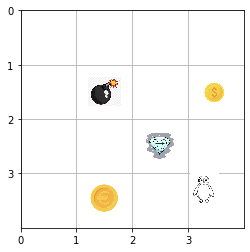

        *************           


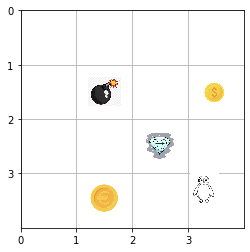

        *************           


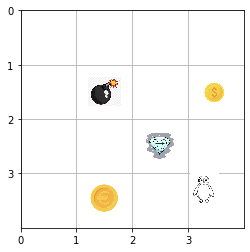

        *************           


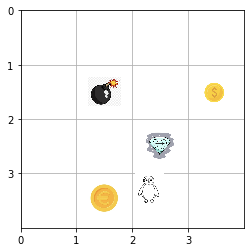

        *************           


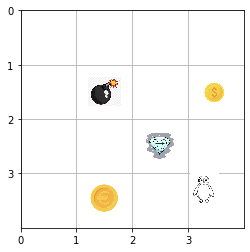

        *************           


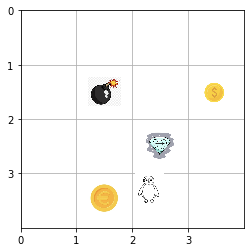

        *************           


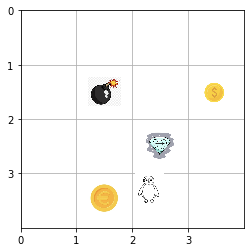

        *************           


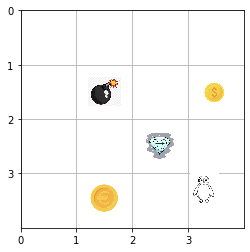

        *************           


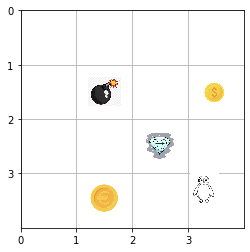

        *************           


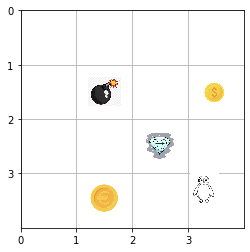

        *************           


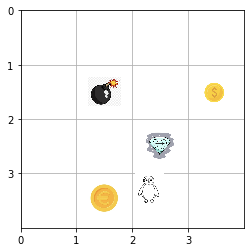

        *************           


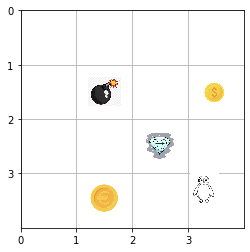

        *************           


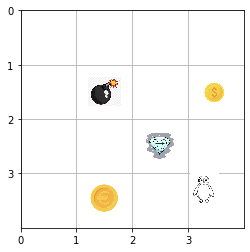

        *************           


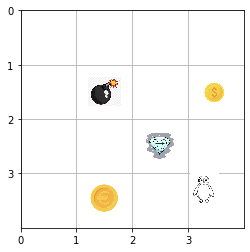

        *************           


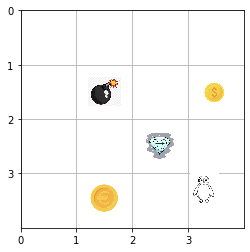

        *************           


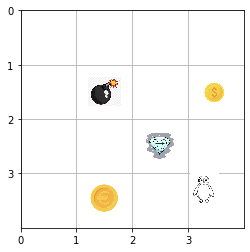

        *************           


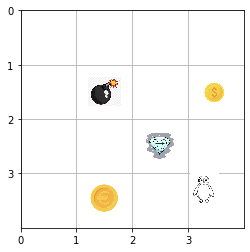

        *************           


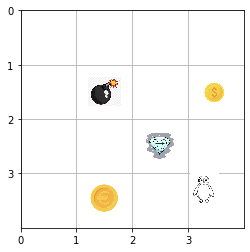

        *************           


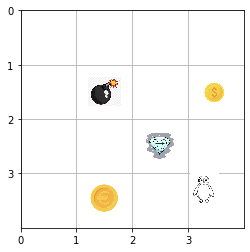

        *************           


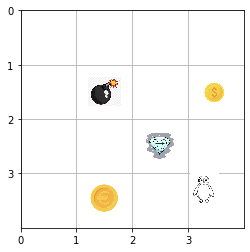

        *************           


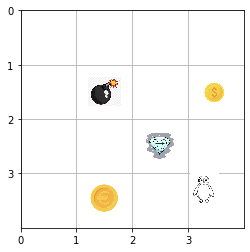

        *************           


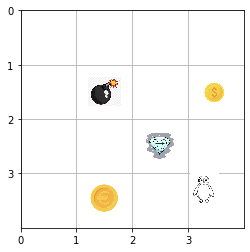

        *************           


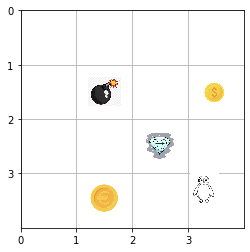

        *************           


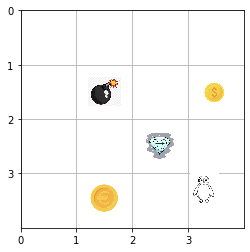

        *************           


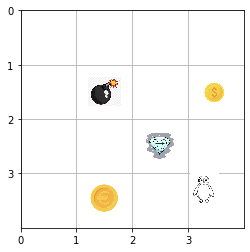

        *************           


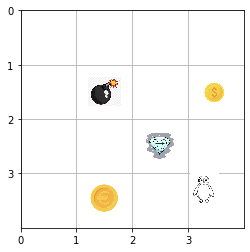

        *************           


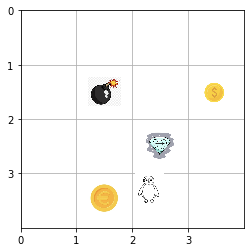

        *************           


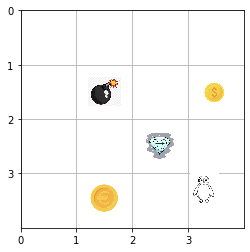

        *************           


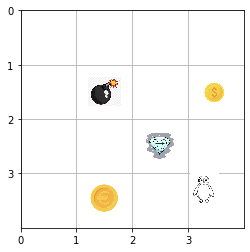

        *************           


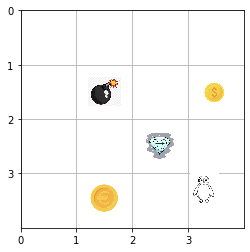

        *************           


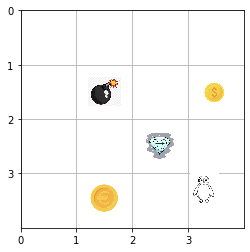

        *************           


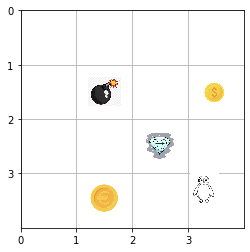

        *************           


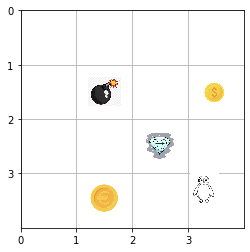

        *************           


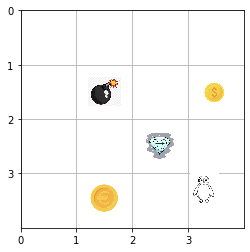

        *************           


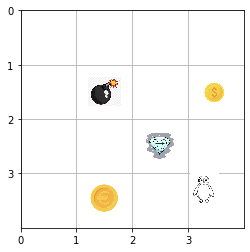

        *************           


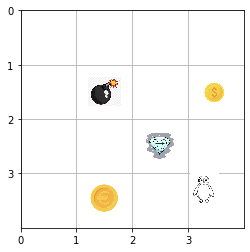

        *************           


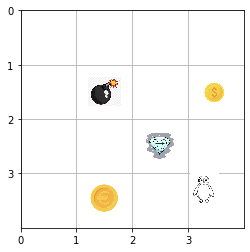

        *************           


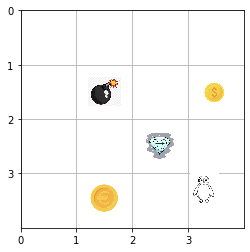

        *************           


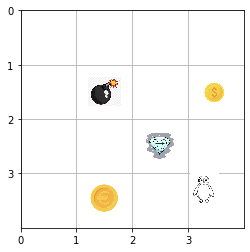

        *************           


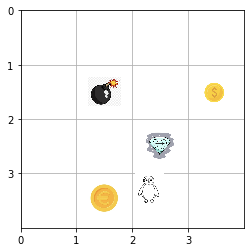

        *************           


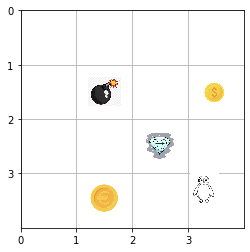

        *************           


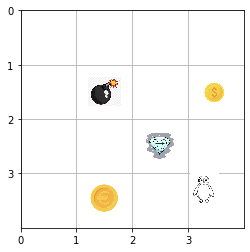

        *************           


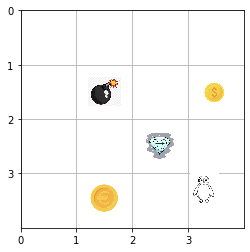

        *************           


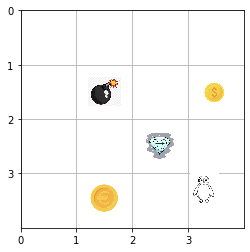

        *************           


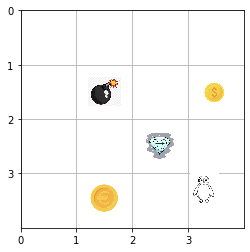

        *************           


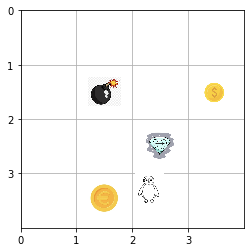

        *************           


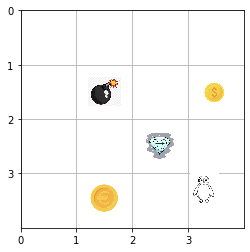

        *************           


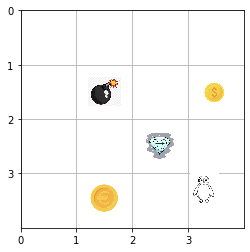

        *************           


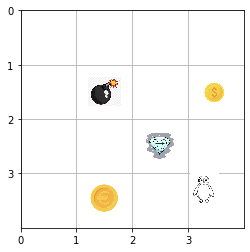

        *************           


In [114]:
env = Gridworld('deterministic')
agent = SarsaAgent(env)
episodes = 5000
min_epsilon = 0.1
epsilon_values = []
reward_values = []

def train(agent, env, epsilon):
    obs, info = env.reset()
    terminated = False
    epsilon_values.append(agent.epsilon_value)
    curr_reward = 0

    while not terminated:
        action = agent.step(env.agent_position)
        state = np.copy(env.agent_position)
        obs, reward, terminated, truncated, info = env.step(action)

        curr_reward += reward
        next_state = np.copy(obs)
        next_action = agent.policy(next_state)
        agent.update(state, action, reward, next_state, next_action)
        # agent.update(state, action, reward,next_state, next_action, env.agent_position)

    rewards_values.append(curr_reward)
    agent.epsilon(max(min_epsilon, epsilon * 0.999))
for episode in range(episodes):
    epsilon = agent.epsilon_value
    train(agent, env, epsilon)
    if episode % 100 == 0:
        env.render()
        plt.show()
        print('        *************           ')

In [115]:
d = print(epsilon_values)
g = print(reward_values)

[0.92, 0.91908, 0.91816092, 0.9172427590800001, 0.9163255163209201, 0.9154091908045991, 0.9144937816137946, 0.9135792878321808, 0.9126657085443486, 0.9117530428358043, 0.9108412897929685, 0.9099304485031755, 0.9090205180546723, 0.9081114975366177, 0.907203386039081, 0.9062961826530419, 0.9053898864703889, 0.9044844965839185, 0.9035800120873346, 0.9026764320752473, 0.9017737556431721, 0.9008719818875289, 0.8999711099056414, 0.8990711387957357, 0.89817206765694, 0.897273895589283, 0.8963766216936938, 0.8954802450720001, 0.8945847648269281, 0.8936901800621011, 0.892796489882039, 0.8919036933921569, 0.8910117896987647, 0.890120777909066, 0.8892306571311569, 0.8883414264740257, 0.8874530850475517, 0.8865656319625042, 0.8856790663305416, 0.8847933872642111, 0.8839085938769469, 0.8830246852830699, 0.8821416605977868, 0.881259518937189, 0.8803782594182519, 0.8794978811588336, 0.8786183832776748, 0.8777397648943972, 0.8768620251295028, 0.8759851631043734, 0.875109177941269, 0.8742340687633277, 

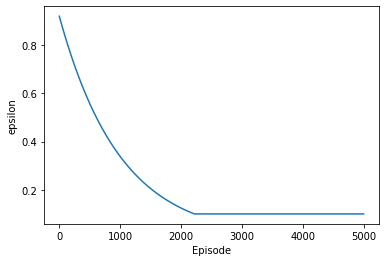

In [116]:
plt.xlabel('Episode')
plt.ylabel('epsilon')
plt.plot(epsilon_values)

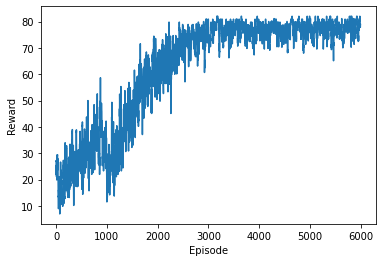

In [117]:
plt.xlabel('Episode')
plt.ylabel('Reward')
rewards = [np.mean(rewards_values[i:i+window_size]) for i in range(len(rewards_values)-window_size+1)]
plt.plot(rewards)
plt.show()

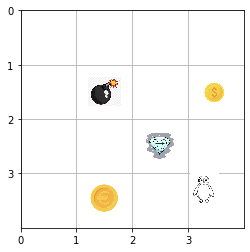

        *************           


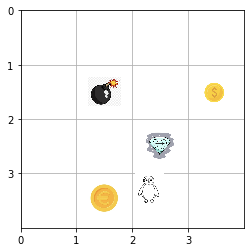

        *************           


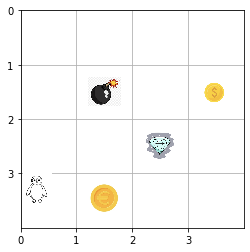

        *************           


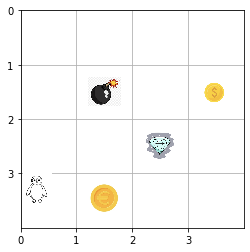

        *************           


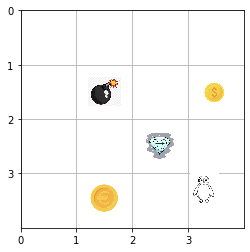

        *************           


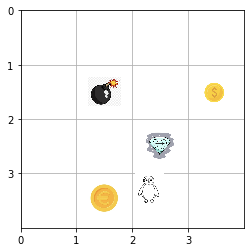

        *************           


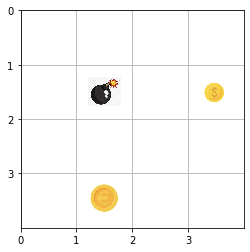

        *************           


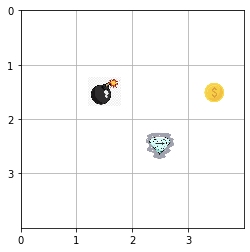

        *************           


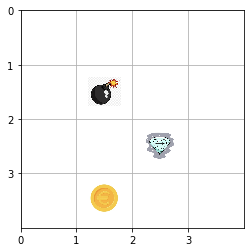

        *************           


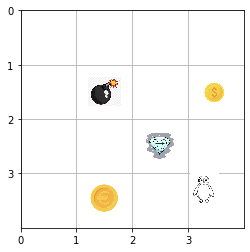

        *************           


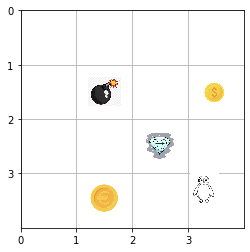

        *************           


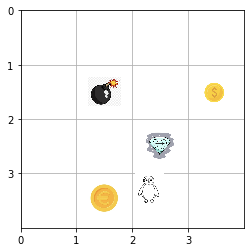

        *************           


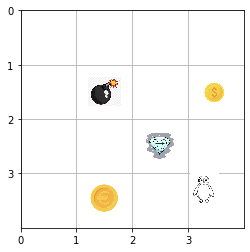

        *************           


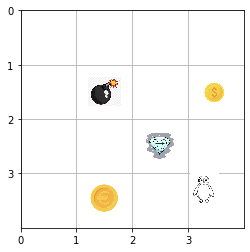

        *************           


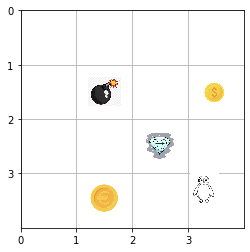

        *************           


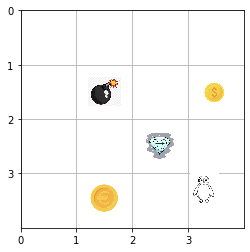

        *************           


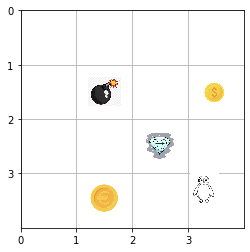

        *************           


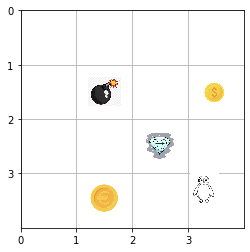

        *************           


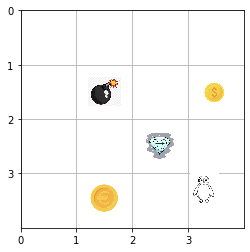

        *************           


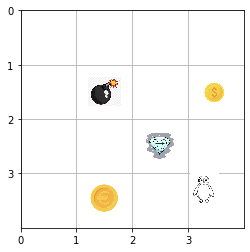

        *************           


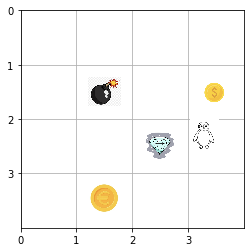

        *************           


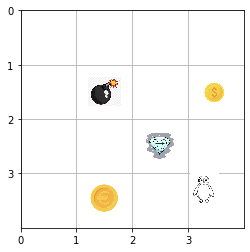

        *************           


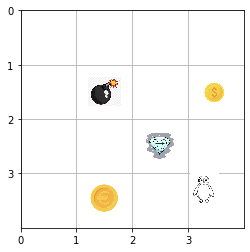

        *************           


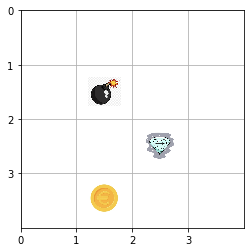

        *************           


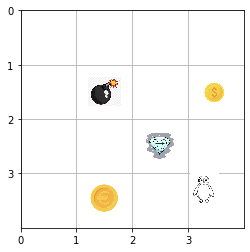

        *************           


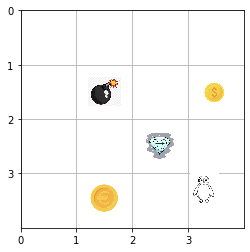

        *************           


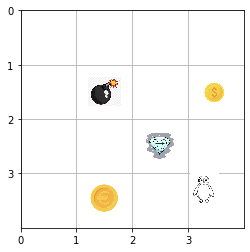

        *************           


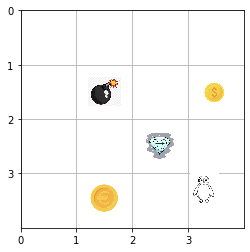

        *************           


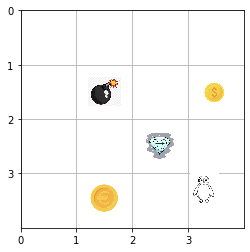

        *************           


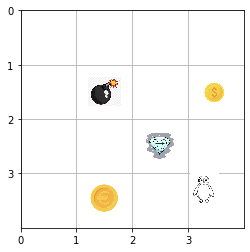

        *************           


In [118]:
env = StochasticGridworld('Stochastic')
agent = SarsaAgent(env)
episodes = 3000
min_epsilon = 0.1
epsilon_values = []
reward_values = []

def train(agent, env, epsilon):
    obs, info = env.reset()
    terminated = False
    epsilon_values.append(agent.epsilon_value)
    curr_reward = 0

    while not terminated:
        action = agent.step(env.agent_position)
        state = np.copy(env.agent_position)
        obs, reward, terminated, truncated, info = env.step(action)

        curr_reward += reward
        next_state = np.copy(obs)
        next_action = agent.policy(next_state)
        agent.update(state, action, reward, next_state, next_action)
        # agent.update(state, action, reward,next_state, next_action, env.agent_position)

    rewards_values.append(curr_reward)
    agent.epsilon(max(min_epsilon, epsilon * 0.999))
for episode in range(episodes):
    epsilon = agent.epsilon_value
    train(agent, env, epsilon)
    if episode % 100 == 0:
        env.render()
        plt.show()
        print('        *************           ')

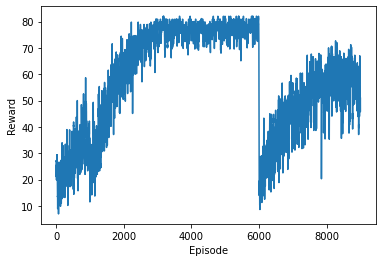

In [119]:
plt.xlabel('Episode')
plt.ylabel('Reward')
rewards = [np.mean(rewards_values[i:i+window_size]) for i in range(len(rewards_values)-window_size+1)]
plt.plot(rewards)
plt.show()

In [120]:
with open('q_tableS.pickle', 'wb') as f:
    pickle.dump(agent.q_learning_table, f)

In [121]:
 b = print(epsilon_values)
 a = print(rewards_values)

[0.92, 0.91908, 0.91816092, 0.9172427590800001, 0.9163255163209201, 0.9154091908045991, 0.9144937816137946, 0.9135792878321808, 0.9126657085443486, 0.9117530428358043, 0.9108412897929685, 0.9099304485031755, 0.9090205180546723, 0.9081114975366177, 0.907203386039081, 0.9062961826530419, 0.9053898864703889, 0.9044844965839185, 0.9035800120873346, 0.9026764320752473, 0.9017737556431721, 0.9008719818875289, 0.8999711099056414, 0.8990711387957357, 0.89817206765694, 0.897273895589283, 0.8963766216936938, 0.8954802450720001, 0.8945847648269281, 0.8936901800621011, 0.892796489882039, 0.8919036933921569, 0.8910117896987647, 0.890120777909066, 0.8892306571311569, 0.8883414264740257, 0.8874530850475517, 0.8865656319625042, 0.8856790663305416, 0.8847933872642111, 0.8839085938769469, 0.8830246852830699, 0.8821416605977868, 0.881259518937189, 0.8803782594182519, 0.8794978811588336, 0.8786183832776748, 0.8777397648943972, 0.8768620251295028, 0.8759851631043734, 0.875109177941269, 0.8742340687633277, 

ValueError: ignored

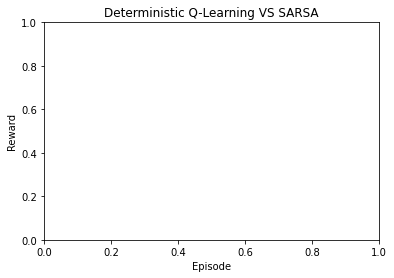

In [122]:
plt.title('Deterministic Q-Learning VS SARSA')
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.plot(a,'orange',label='Q-Learning')
plt.plot(g, 'lightblue',label = 'SARSA')
plt.legend()

In [ ]:
plt.title('Stochastic Q-Learning VS SARSA')
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.plot(a,'orange',label='Q-Learning')
plt.plot(g, 'lightblue',label = 'SARSA')
plt.legend()